In [1]:
#!pip install transformers datasets tensorflow


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

In [3]:
# Configuración
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3
MODEL_NAME = "dccuchile/bert-base-spanish-wwm-cased"
NUM_CLASSES = 2  # negativo, positivo

In [4]:
# 1. Cargar tokenizer y modelo
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_CLASSES)

c:\Users\aluca\miniconda3\envs\tf_im_test\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# 2. Leer y limpiar el dataset
df = pd.read_excel('../Datos/DB_Comentarios_Clean.xlsx')
df = df.dropna()

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

# Configuración
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3
MODEL_NAME = "dccuchile/bert-base-spanish-wwm-cased"
NUM_CLASSES = 2  # negativo, positivo

# 1. Cargar tokenizer y modelo
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_CLASSES)

# 2. Leer y limpiar el dataset
df = pd.read_excel('../Datos/DB_Comentarios_Clean.xlsx')
df = df.dropna()

# 3. Mapear calificaciones a sentimientos
rating_to_label = {
    1: "negativo",
    2: "negativo",
    3: "negativo",
    4: "positivo",
    5: "positivo",
}
df["sentimiento"] = df["calificacion"].map(rating_to_label)

# 4. Codificar sentimiento a números
label_to_int = {"negativo": 0, "positivo": 1}
df["sentimiento_id"] = df["sentimiento"].map(label_to_int)

c:\Users\aluca\miniconda3\envs\tf_im_test\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
df.head()

,fecha,calificacion,comentario,comentarios_limpios_spacy,sentimiento,sentimiento_id
0,01 ene. 2024,1,"Producto con terminados horribles, manchado, p...",terminado horrible manchado pintura corrido di...,negativo,0
1,01 may. 2023,1,El producto es un poco ordinario y tuve que ma...,ordinario tener mandar él reparar rapido mes c...,negativo,0
2,02 oct. 2024,1,Talla incorrecta.,tallar incorrecto,negativo,0
3,02 sep. 2019,1,Definitivamente no cuadra en el pie.,definitivamente cuadrar pie,negativo,0
4,03 ene. 2025,1,"No son nada cómodos, la plantilla se corre y l...",comodo plantilla correr suela delgado,negativo,0


In [8]:
df["sentimiento_id"].value_counts()

sentimiento_id
1    4073
0     400
Name: count, dtype: int64

In [9]:
# 5. Dividir en train/test
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df["sentimiento_id"], random_state=42)

In [10]:
# 6. Tokenizar textos
def encode_texts(texts, tokenizer, max_len=MAX_LEN):
    return tokenizer(
        texts.tolist(),
        max_length=max_len,
        truncation=True,
        padding=True,
        return_tensors='tf'
    )

In [11]:
X_train_enc = encode_texts(df_train['comentarios_limpios_spacy'], tokenizer)
X_test_enc = encode_texts(df_test['comentarios_limpios_spacy'], tokenizer)
y_train = tf.convert_to_tensor(df_train['sentimiento_id'].astype("int32").values)
y_test = tf.convert_to_tensor(df_test['sentimiento_id'].astype("int32").values)

In [12]:
# 7. Compilar modelo
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


In [13]:
# 8. Entrenamiento
history = model.fit(
    x={'input_ids': X_train_enc['input_ids'], 'attention_mask': X_train_enc['attention_mask']},
    y=y_train,
    validation_data=(
        {'input_ids': X_test_enc['input_ids'], 'attention_mask': X_test_enc['attention_mask']},
        y_test
    ),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/3
224/224 [==============================] - 545s 2s/step - loss: 0.2634 - accuracy: 0.9094 - val_loss: 0.2307 - val_accuracy: 0.9106
Epoch 2/3
224/224 [==============================] - 536s 2s/step - loss: 0.1972 - accuracy: 0.9178 - val_loss: 0.2179 - val_accuracy: 0.9073
Epoch 3/3
224/224 [==============================] - 542s 2s/step - loss: 0.1419 - accuracy: 0.9452 - val_loss: 0.2288 - val_accuracy: 0.9028


In [14]:
# 9. Evaluación
loss, acc = model.evaluate(
    {'input_ids': X_test_enc['input_ids'], 'attention_mask': X_test_enc['attention_mask']},
    y_test
)
print(f"Evaluación final ➤ Loss: {loss:.4f} - Accuracy: {acc:.4f}")

28/28 [==============================] - 20s 703ms/step - loss: 0.2288 - accuracy: 0.9028
Evaluación final ➤ Loss: 0.2288 - Accuracy: 0.9028


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

28/28 [==============================] - 20s 662ms/step
📋 Reporte de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.45      0.36      0.40        80
    Positivo       0.94      0.96      0.95       815

    accuracy                           0.90       895
   macro avg       0.69      0.66      0.67       895
weighted avg       0.89      0.90      0.90       895



c:\Users\aluca\miniconda3\envs\tf_im_test\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


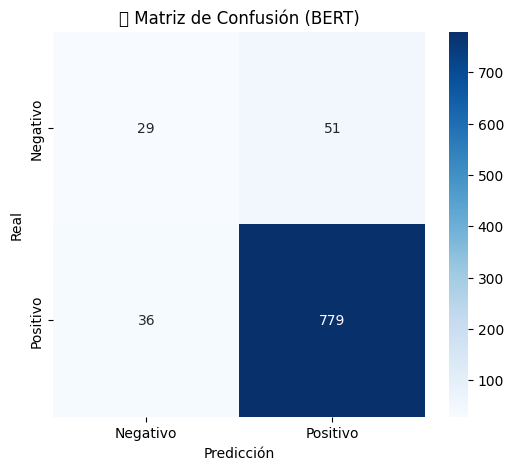

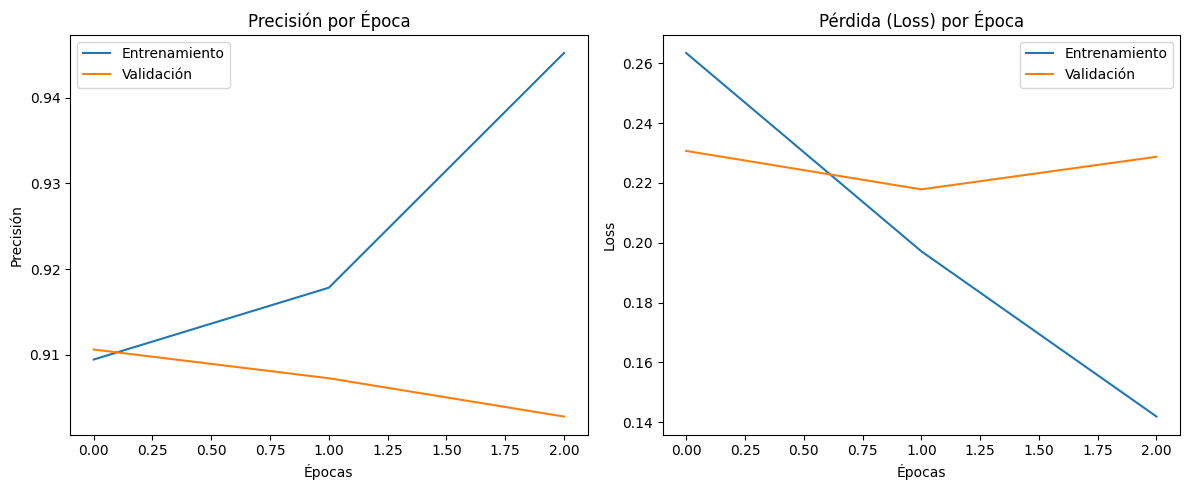

In [16]:
# 1. Obtener predicciones
y_pred_probs = model.predict({'input_ids': X_test_enc['input_ids'], 'attention_mask': X_test_enc['attention_mask']})
y_pred = tf.argmax(y_pred_probs.logits, axis=1).numpy()

# 2. Reporte de clasificación
print("📋 Reporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=["Negativo", "Positivo"]))

# 3. Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.title("🔍 Matriz de Confusión (BERT)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# 4. Graficar precisión y pérdida del entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.title('Precisión por Época')
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.title('Pérdida (Loss) por Época')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


### Probar un modelo de clasificacion binaria

In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification

In [18]:
# -------------------------------
# 1. Configuración
# -------------------------------
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3
MODEL_NAME = "dccuchile/bert-base-spanish-wwm-cased"
NUM_CLASSES = 2  # Clasificación binaria: 0 = negativo, 1 = positivo

In [19]:
# -------------------------------
# 2. Cargar tokenizer y modelo
# -------------------------------
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_CLASSES)

c:\Users\aluca\miniconda3\envs\tf_im_test\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
# -------------------------------
# 3. Cargar y preparar los datos
# -------------------------------
df = pd.read_excel('../Datos/DB_Comentarios_Clean.xlsx')
df = df.dropna()

In [21]:
# Mapear calificación a sentimiento binario
rating_to_label = {
    1: "negativo",
    2: "negativo",
    3: "positivo",
    4: "positivo",
    5: "positivo",
}
df["sentimiento"] = df["calificacion"].map(rating_to_label)
label_to_int = {"negativo": 0, "positivo": 1}
df["sentimiento_id"] = df["sentimiento"].map(label_to_int)

In [22]:
df['sentimiento_id'].value_counts()

sentimiento_id
1    4282
0     191
Name: count, dtype: int64

In [23]:
# -------------------------------
# 4. Tokenización
# -------------------------------
def encode_texts(texts, tokenizer, max_len=MAX_LEN):
    return tokenizer(
        texts.tolist(),
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

encodings = encode_texts(df["comentarios_limpios_spacy"], tokenizer)
X_input_ids = encodings["input_ids"]
X_attention_mask = encodings["attention_mask"]
y = tf.convert_to_tensor(df["sentimiento_id"].astype("int32").values)

# Convertir a NumPy para hacer split
X_input_ids_np = X_input_ids.numpy()
X_attention_mask_np = X_attention_mask.numpy()
y_np = y.numpy()

In [24]:
# -------------------------------
# 5. División train/test
# -------------------------------
X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    X_input_ids_np, X_attention_mask_np, y_np, test_size=0.2, stratify=y_np, random_state=42
)

# Convertir de nuevo a tensores
X_train_ids = tf.convert_to_tensor(X_train_ids)
X_test_ids = tf.convert_to_tensor(X_test_ids)
X_train_mask = tf.convert_to_tensor(X_train_mask)
X_test_mask = tf.convert_to_tensor(X_test_mask)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)


In [25]:
print(y_train.shape)
print(y_test.shape)

(3578,)
(895,)


In [26]:
# -------------------------------
# 6. Compilar el modelo
# -------------------------------
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [27]:
# -------------------------------
# 7. Entrenamiento
# -------------------------------
history = model.fit(
    x={'input_ids': X_train_ids, 'attention_mask': X_train_mask},
    y=y_train,
    validation_data=({'input_ids': X_test_ids, 'attention_mask': X_test_mask}, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/3
224/224 [==============================] - 806s 4s/step - loss: 0.1623 - accuracy: 0.9530 - val_loss: 0.1210 - val_accuracy: 0.9575
Epoch 2/3
224/224 [==============================] - 807s 4s/step - loss: 0.1171 - accuracy: 0.9564 - val_loss: 0.1370 - val_accuracy: 0.9575
Epoch 3/3
224/224 [==============================] - 820s 4s/step - loss: 0.0799 - accuracy: 0.9740 - val_loss: 0.1621 - val_accuracy: 0.9430


In [28]:
# -------------------------------
# 8. Evaluación
# -------------------------------
loss, acc = model.evaluate(
    {'input_ids': X_test_ids, 'attention_mask': X_test_mask},
    y_test
)
print(f"Evaluación final ➤ Loss: {loss:.4f} - Accuracy: {acc:.4f}")

28/28 [==============================] - 58s 2s/step - loss: 0.1621 - accuracy: 0.9430
Evaluación final ➤ Loss: 0.1621 - Accuracy: 0.9430


28/28 [==============================] - 59s 2s/step
📋 Reporte de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.35      0.39      0.37        38
    Positivo       0.97      0.97      0.97       857

    accuracy                           0.94       895
   macro avg       0.66      0.68      0.67       895
weighted avg       0.95      0.94      0.94       895



c:\Users\aluca\miniconda3\envs\tf_im_test\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


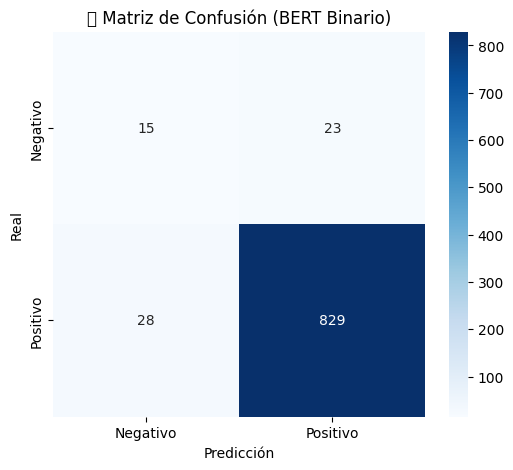

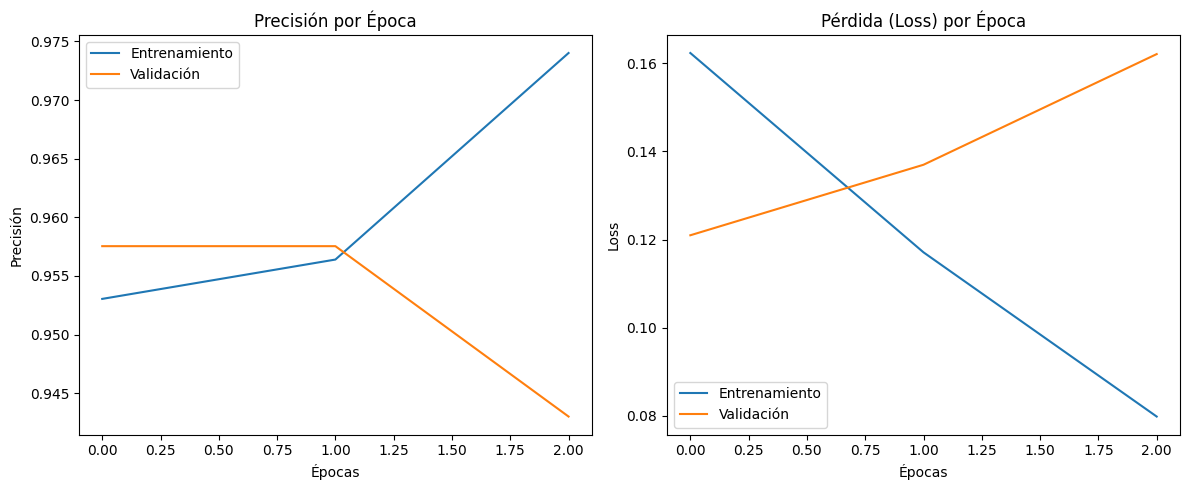

In [29]:
# 1. Obtener predicciones
y_pred_probs = model.predict({'input_ids': X_test_ids, 'attention_mask': X_test_mask})
y_pred = tf.argmax(y_pred_probs.logits, axis=1).numpy()

# 2. Reporte de clasificación
print("📋 Reporte de Clasificación:")
print(classification_report(y_test.numpy(), y_pred, target_names=["Negativo", "Positivo"]))

# 3. Matriz de Confusión
cm = confusion_matrix(y_test.numpy(), y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.title("🔍 Matriz de Confusión (BERT Binario)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# 4. Graficar precisión y pérdida del entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.title('Precisión por Época')
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.title('Pérdida (Loss) por Época')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

### Variacion con class_weight

c:\Users\aluca\miniconda3\envs\tf_im_test\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pesos de clase: {0: 5.590625, 1: 0.549109883364027}
Epoch 1/3
224/224 [==============================] - 1147s 5s/step - loss: 0.3456 - accuracy: 0.8527 - val_loss: 0.3206 - val_accuracy: 0.9006
Epoch 2/3
224/224 [==============================] - 1103s 5s/step - loss: 0.2274 - accuracy: 0.9162 - val_loss: 0.3759 - val_accuracy: 0.8637
Epoch 3/3
28/28 [==============================] - 67s 2s/step - loss: 0.3105 - accuracy: 0.9140

Evaluación final ➤ Loss: 0.3105 - Accuracy: 0.9140
28/28 [==============================] - 69s 2s/step

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.51      0.88      0.65        80
    Positivo       0.99      0.92      0.95       815

    accuracy                           0.91       895
   macro avg       0.75      0.90      0.80       895
weighted avg       0.94      0.91      0.92       895



c:\Users\aluca\miniconda3\envs\tf_im_test\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


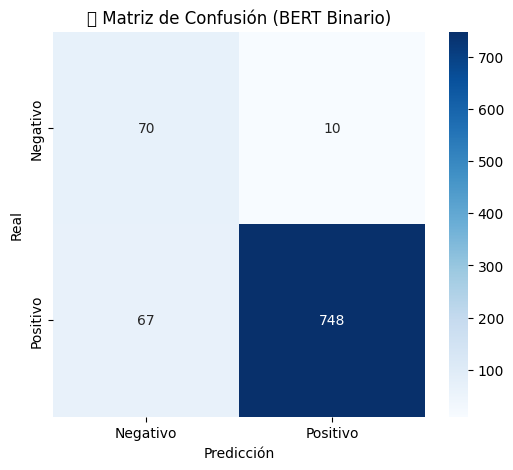

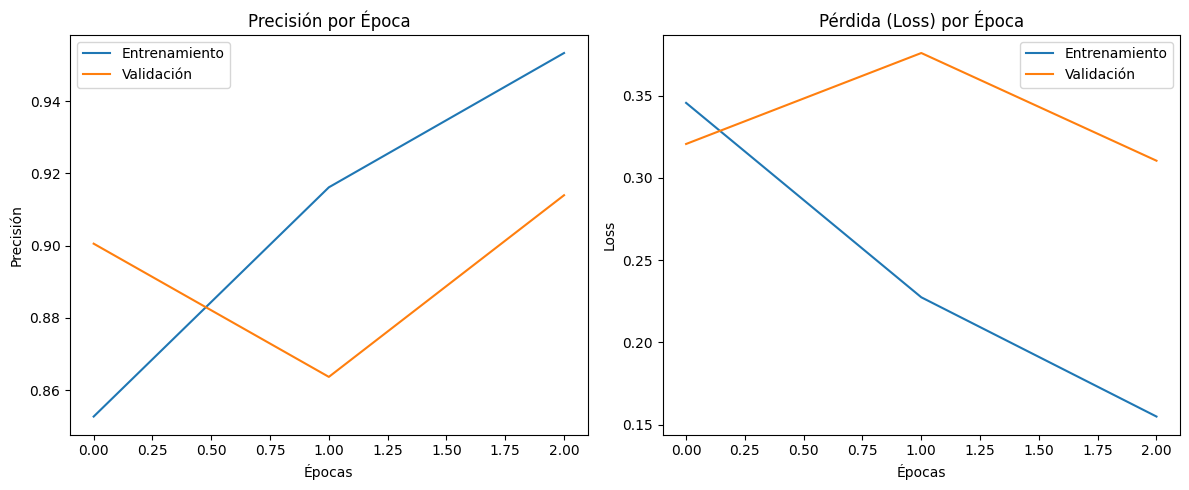

In [30]:
# 1. Instalación de librerías necesarias
#!pip install transformers datasets tensorflow -q

# 2. Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 3. Configuración
MODEL_NAME = "dccuchile/bert-base-spanish-wwm-cased"
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3
NUM_CLASSES = 2  # Binario: 0 = negativo, 1 = positivo

# 4. Cargar tokenizer y modelo
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_CLASSES)

# 5. Cargar y preparar los datos
df = pd.read_excel('../Datos/DB_Comentarios_Clean.xlsx')
df = df.dropna()

# Mapeo binario de sentimiento
rating_to_label = {1: "negativo", 2: "negativo", 3: "negativo", 4: "positivo", 5: "positivo"}
df["sentimiento"] = df["calificacion"].map(rating_to_label)
label_to_int = {"negativo": 0, "positivo": 1}
df["sentimiento_id"] = df["sentimiento"].map(label_to_int)

# 6. Tokenización
def encode_texts(texts, tokenizer, max_len=MAX_LEN):
    return tokenizer(
        texts.tolist(),
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

# 7. División train/test
X_train, X_test, y_train, y_test = train_test_split(
    df["comentario"],
    df["sentimiento_id"],
    test_size=0.2,
    stratify=df["sentimiento_id"],
    random_state=42
)

X_train_enc = encode_texts(X_train, tokenizer)
X_test_enc = encode_texts(X_test, tokenizer)
y_train = tf.convert_to_tensor(y_train.astype("int32").values)
y_test = tf.convert_to_tensor(y_test.astype("int32").values)

# 8. Calcular pesos de clase
y_train_np = y_train.numpy()
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_np),
    y=y_train_np
)
class_weights = dict(enumerate(class_weights))
print("Pesos de clase:", class_weights)

# 9. Compilar el modelo
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# 10. Entrenamiento
history = model.fit(
    x={'input_ids': X_train_enc['input_ids'], 'attention_mask': X_train_enc['attention_mask']},
    y=y_train,
    validation_data=(
        {'input_ids': X_test_enc['input_ids'], 'attention_mask': X_test_enc['attention_mask']},
        y_test
    ),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights
)

# 11. Evaluación final
loss, acc = model.evaluate(
    {'input_ids': X_test_enc['input_ids'], 'attention_mask': X_test_enc['attention_mask']},
    y_test
)
print(f"\nEvaluación final ➤ Loss: {loss:.4f} - Accuracy: {acc:.4f}")

# 12. Reporte de Clasificación y Matriz de Confusión
y_pred_probs = model.predict({'input_ids': X_test_enc['input_ids'], 'attention_mask': X_test_enc['attention_mask']})
y_pred = tf.argmax(y_pred_probs.logits, axis=1).numpy()

print("\n📋 Reporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=["Negativo", "Positivo"]))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.title("🔍 Matriz de Confusión (BERT Binario)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# 13. Gráficas de precisión y pérdida
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.title('Precisión por Época')
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.title('Pérdida (Loss) por Época')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()
